In [2]:
import torch
import functools
print = functools.partial(print, flush=True)
import numpy as np 
import math
import functools
from torch.autograd import Function

In [3]:

import math
import copy

################ Zhirui on 12-30-2020 ################
# U-layer 
######################################################
def get_index_list(input,target):
    index_list = []
    try:
        beg_pos = 0
        while True:
            find_pos = input.index(target,beg_pos)
            index_list.append(find_pos)
            beg_pos = find_pos+1
    except Exception as exception:        
        pass    
    return index_list

def change_sign(sign,bin):
    affect_num = [bin]
    one_positions = []
    
    try:
        beg_pos = 0
        while True:
            find_pos = bin.index("1",beg_pos)
            one_positions.append(find_pos)
            beg_pos = find_pos+1
    except Exception as exception:
        # print("Not Found")
        pass
    
    for k,v in sign.items():
        change = True
        for pos in one_positions:
            if k[pos]=="0":                
                change = False
                break
        if change:
            sign[k] = -1*v
    

def find_start(affect_count_table,target_num):
    for k in list(affect_count_table.keys())[::-1]:
        if target_num<=k:
            return k


def recursive_change(direction,start_point,target_num,sign,affect_count_table,quantum_gates):
    
    if start_point == target_num:
        # print("recursive_change: STOP")
        return
    
    gap = int(math.fabs(start_point-target_num))    
    step = find_start(affect_count_table,gap)
    change_sign(sign,affect_count_table[step])
    quantum_gates.append(affect_count_table[step])
    
    if direction=="r": 
        # print("recursive_change: From",start_point,"Right(-):",step)
        start_point = start_point - step
        direction = "l"
        recursive_change(direction,start_point,target_num,sign,affect_count_table,quantum_gates)
        
    else:        
        # print("recursive_change: From",start_point,"Left(+):",step)
        start_point = start_point + step
        direction = "r"
        recursive_change(direction,start_point,target_num,sign,affect_count_table,quantum_gates)
        
    

def guarntee_upper_bound_algorithm(sign,target_num,total_len,digits):        
    flag = "0"+str(digits)+"b"
    pre_num = 0
    affect_count_table = {}
    quantum_gates = []
    for i in range(digits):
        cur_num = pre_num + pow(2,i)
        pre_num = cur_num
        binstr_cur_num = format(cur_num,flag) 
        affect_count_table[int(pow(2,binstr_cur_num.count("0")))] = binstr_cur_num   
        
    if target_num in affect_count_table.keys():
        quantum_gates.append(affect_count_table[target_num])
        change_sign(sign,affect_count_table[target_num])    
    else:
        direction = "r"
        start_point = find_start(affect_count_table,target_num)
        quantum_gates.append(affect_count_table[start_point])
        change_sign(sign,affect_count_table[start_point])
        recursive_change(direction,start_point,target_num,sign,affect_count_table,quantum_gates)
    
    return quantum_gates

def qf_map_extract_from_weight(weights):    
    # Find Z control gates according to weights
    w = (weights.detach().cpu().numpy())
    total_len = len(w)
    target_num = np.count_nonzero(w == -1)
    if target_num > total_len/2:
        w = w*-1
    target_num = np.count_nonzero(w == -1)    
    digits = int(math.log(total_len,2))
    flag = "0"+str(digits)+"b"
    max_num = int(math.pow(2,digits))
    sign = {}
    for i in range(max_num):        
        sign[format(i,flag)] = +1
    quantum_gates = guarntee_upper_bound_algorithm(sign,target_num,total_len,digits)
    
        
    # Build the mapping from weight to final negative num 
    fin_sign = list(sign.values())
    fin_weig = [int(x) for x in list(w)]
    
    # print(fin_sign)
    # print(fin_weig)
    sign_neg_index = []    
    try:
        beg_pos = 0
        while True:
            find_pos = fin_sign.index(-1,beg_pos)            
            # qiskit_position = int(format(find_pos,flag)[::-1],2)                            
            sign_neg_index.append(find_pos)
            beg_pos = find_pos+1
    except Exception as exception:        
        pass    
    

    weight_neg_index = []
    try:
        beg_pos = 0
        while True:
            find_pos = fin_weig.index(-1,beg_pos)
            weight_neg_index.append(find_pos)
            beg_pos = find_pos+1
    except Exception as exception:        
        pass    
    map = {}
    for i in range(len(sign_neg_index)):
        map[sign_neg_index[i]] = weight_neg_index[i]
    ret_index = list([-1 for i in range(len(fin_weig))])

    for k,v in map.items():
        ret_index[k]=v

    for i in range(len(fin_weig)):
        if ret_index[i]!=-1:
            continue
        for j in range(len(fin_weig)):
            if j not in ret_index:
                ret_index[i]=j
                break
    return quantum_gates,ret_index

################ Zhirui on 12-30-2020 ################
# ffnn-layer 
######################################################
def AinB(A,B):
    idx_a = []
    for i in range(len(A)):
        if A[i]=="1":
            idx_a.append(i)    
    flag = True
    for j in idx_a:
        if B[j]=="0":
            flag=False
            break
    return flag
            
        
def FFNN_Create_Weight(weights):        
    # Find Z control gates according to weights
    w = (weights.detach().cpu().numpy())
    total_len = len(w)            
    digits = int(math.log(total_len,2))
    flag = "0"+str(digits)+"b"
    max_num = int(math.pow(2,digits))
    sign = {}
    for i in range(max_num):        
        sign[format(i,flag)] = +1    
    sign_expect = {}
    for i in range(max_num):
        sign_expect[format(i,flag)] = int(w[i])    
    
    order_list = []
    for i in range(digits+1):
        for key in sign.keys():
            if key.count("1") == i:
                order_list.append(key)    
    
    gates = []    
    sign_cur = copy.deepcopy(sign_expect)
    for idx in range(len(order_list)):
        key = order_list[idx]
        if sign_cur[key] == -1:
            gates.append(key)
            for cor_idx in range(idx,len((order_list))):
                if AinB(key,order_list[cor_idx]):
                    sign_cur[order_list[cor_idx]] = (-1)*sign_cur[order_list[cor_idx]]    
    return gates

################ Zhirui on 12-30-2020 ################
# commons
######################################################

def gates_to_cost(gates):
    cost = 0
    for gate in gates:
        num_one = gate.count("1")
        if num_one==1:
            cost += 1
        else:
            cost += (num_one-1)*2-1
    return cost
        

class BinarizeF(Function):

    @staticmethod
    def forward(cxt, input):
        output = input.new(input.size())
        output[input >= 0] = 1
        output[input < 0] = -1

        return output

    @staticmethod
    def backward(cxt, grad_output):
        grad_input = grad_output.clone()
        return grad_input


# aliases
binarize = BinarizeF.apply




In [4]:

################ Zhirui on 12-30-2020 ################
# caculate the cost of FFNN and U-Layer for a set number of qubits (4-12)
######################################################

QF_Cost={}
FFNN_Cost={}
MLP_Cost={}

qf_net_cost = 0
ffnn_cost = 0
for e in range(4,12):
    QF_Cost[e]=[]
    FFNN_Cost[e]=[]
    MLP_Cost[e]=[]
    for r in range(50):
        MLP_Cost[e].append(2**e*2+e)
        
        x=torch.rand(2**e)-0.5       
        x = binarize(x)
        
        sq_cost = e+e*2-1
        
        quantum_gates,ret_index = qf_map_extract_from_weight(x)
        qf_net_cost = gates_to_cost(quantum_gates)+sq_cost
        
        gates = FFNN_Create_Weight(x)
        ffnn_cost = gates_to_cost(gates)+sq_cost
        
        QF_Cost[e].append(qf_net_cost)
        FFNN_Cost[e].append(ffnn_cost)
        
        # print(e,2**e*2+e,qf_net_cost,ffnn_cost)

In [5]:
################ Zhirui on 12-30-2020 ################
# caculate how many times is the cost of FFNN and U-Layer for a set number of qubits (4-12)
######################################################

for e in range(4,12):        
    print(e,end=" ")

mean_mlp_cost = []
mean_ffnn_cost = []
mean_qf_cost = []
mean_mlp_div_qf = []
x_axis = []
print()
for e in range(4,12):    
    print(float(sum(MLP_Cost[e])/len(MLP_Cost[e])),end=" ")
    mean_mlp_cost.append(float(sum(MLP_Cost[e])/len(MLP_Cost[e])))
        
print()
print()


for e in range(4,12):    
    print(e,end=" ")
print()
for e in range(4,12):    
    print(float(sum(FFNN_Cost[e])/len(FFNN_Cost[e])),end=" ")
    mean_ffnn_cost.append(float(sum(FFNN_Cost[e])/len(FFNN_Cost[e])))
    
print()
print()


for e in range(4,12):    
    print(e,end=" ")
    x_axis.append(e)
    
print()
for e in range(4,12):    
    print(float(sum(QF_Cost[e])/len(QF_Cost[e])),end=" ")
    mean_qf_cost.append(float(sum(QF_Cost[e])/len(QF_Cost[e])))

for i in range(0,len(mean_qf_cost)):
    times = int(float(mean_mlp_cost[i])/ float(mean_qf_cost[i]))
    mean_mlp_div_qf.append(times)

4 5 6 7 8 9 10 11 
36.0 69.0 134.0 263.0 520.0 1033.0 2058.0 4107.0 

4 5 6 7 8 9 10 11 
22.54 51.64 119.3 292.76 664.88 1572.78 3648.18 8231.18 

4 5 6 7 8 9 10 11 
15.84 20.38 27.5 33.58 41.96 50.88 60.28 69.16 

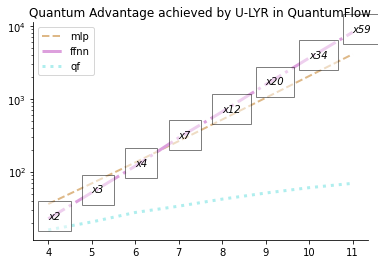

In [6]:
import matplotlib.pyplot as plt

# x_data = ['2011','2012','2013','2014','2015','2016','2017']
# y_data = [58000,60200,63000,71000,84000,90500,107000]
# y_data2 = [52000,54200,51500,58300,56800,59500,62700]

ln1, = plt.plot(x_axis,mean_mlp_cost,color='burlywood',linewidth=2.0,linestyle='--')
ln2, = plt.plot(x_axis,mean_ffnn_cost,color='plum',linewidth=3.0,linestyle='-.')
ln3, = plt.plot(x_axis,mean_qf_cost,color='paleturquoise',linewidth=3.0,linestyle=':')

plt.title("Quantum Advantage achieved by U-LYR in QuantumFlow") #设置标题及字体

plt.legend(handles=[ln1,ln2,ln3],labels=['mlp','ffnn','qf'])
plt.yscale('log')
ax = plt.gca()

for i in range(0,len(mean_mlp_div_qf)):
    ax.text(i+4,mean_ffnn_cost[i] ,'x'+ str(mean_mlp_div_qf[i]),style='italic',bbox={'facecolor':'white','alpha':0.5,'pad':10})
ax.spines['right'].set_color('none')  # right边框属性设置为none 不显示
ax.spines['top'].set_color('none')    # top边框属性设置为none 不显示

plt.show()